## Videogames Sales Prediction

This project aims to develop and train a model to predict videogames sales. The dataset used to train the model was obtained on Kagle and it's called Video Games Sales 2019 dataset.

In [8]:
import numpy as np
from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import re
import random

import sklearn
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

### Data Wrangling

In [9]:
df = pd.read_csv('vgsales.csv')
df.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


In [10]:
df.shape

(55792, 23)

In [11]:
df.Year.min(), df.Year.max()

(1970.0, 2020.0)

The dataset consists of 23 different features of 55792 videogames released between 1970 and 2020.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55792 entries, 0 to 55791
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            55792 non-null  int64  
 1   Name            55792 non-null  object 
 2   basename        55792 non-null  object 
 3   Genre           55792 non-null  object 
 4   ESRB_Rating     23623 non-null  object 
 5   Platform        55792 non-null  object 
 6   Publisher       55792 non-null  object 
 7   Developer       55775 non-null  object 
 8   VGChartz_Score  0 non-null      float64
 9   Critic_Score    6536 non-null   float64
 10  User_Score      335 non-null    float64
 11  Total_Shipped   1827 non-null   float64
 12  Global_Sales    19415 non-null  float64
 13  NA_Sales        12964 non-null  float64
 14  PAL_Sales       13189 non-null  float64
 15  JP_Sales        7043 non-null   float64
 16  Other_Sales     15522 non-null  float64
 17  Year            54813 non-null 

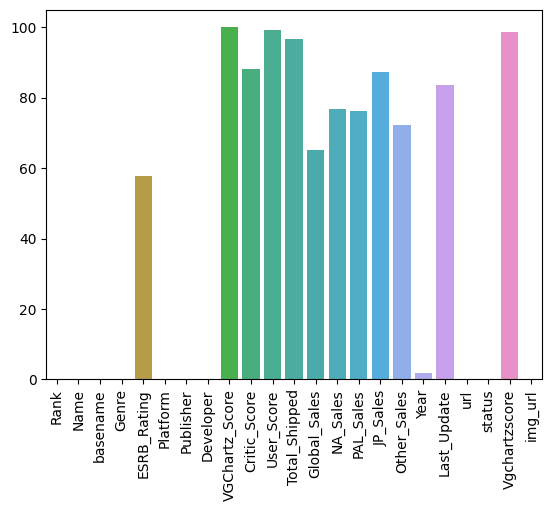

In [13]:
missing_pct = df.isna().mean() * 100
sns.barplot(missing_pct.index, missing_pct.values)
plt.xticks(rotation = 90)
plt.show()

As Global Sales is going to be our label, we can't work with datapoints that don't have that data, so we're going to drop every row that doesn't contain Global Sales, which unfortunately as seen before accounts for 65% of our dataset.

In [14]:
df = df[df['Global_Sales'].notna()]
df.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
19,20,Grand Theft Auto V,grand-theft-auto-v,Action,M,PS3,Rockstar Games,Rockstar North,NaN,9.4,...,6.37,9.85,0.99,3.12,2013.0,NaN,http://www.vgchartz.com/game/65884/grand-theft...,1,NaN,/games/boxart/full_6510540AmericaFrontccc.jpg
20,21,Grand Theft Auto V,grand-theft-auto-v,Action,M,PS4,Rockstar Games,Rockstar North,NaN,9.7,...,6.06,9.71,0.60,3.02,2014.0,03rd Jan 18,http://www.vgchartz.com/game/83196/grand-theft...,1,NaN,/games/boxart/full_5563178AmericaFrontccc.jpg
30,31,Grand Theft Auto: Vice City,grand-theft-auto-vice-city,Action,M,PS2,Rockstar Games,Rockstar North,NaN,9.6,...,8.41,5.49,0.47,1.78,2002.0,NaN,http://www.vgchartz.com/game/896/grand-theft-a...,1,NaN,/games/boxart/827563ccc.jpg
32,33,Grand Theft Auto V,grand-theft-auto-v,Action,M,X360,Rockstar Games,Rockstar North,NaN,NaN,...,9.06,5.33,0.06,1.42,2013.0,NaN,http://www.vgchartz.com/game/65883/grand-theft...,1,NaN,/games/boxart/full_9218923AmericaFrontccc.jpg
34,35,Call of Duty: Black Ops 3,call-of-duty-black-ops-3,Shooter,M,PS4,Activision,Treyarch,NaN,NaN,...,6.18,6.05,0.41,2.44,2015.0,14th Jan 18,http://www.vgchartz.com/game/85359/call-of-dut...,1,NaN,/games/boxart/full_4990510AmericaFrontccc.jpg


In [15]:
df.isna().mean()

Rank              0.000000
Name              0.000000
basename          0.000000
Genre             0.000000
ESRB_Rating       0.288694
Platform          0.000000
Publisher         0.000000
Developer         0.000206
VGChartz_Score    1.000000
Critic_Score      0.779809
User_Score        0.991141
Total_Shipped     1.000000
Global_Sales      0.000000
NA_Sales          0.332269
PAL_Sales         0.320680
JP_Sales          0.637239
Other_Sales       0.200515
Year              0.001957
Last_Update       0.803605
url               0.000000
status            0.000000
Vgchartzscore     0.976771
img_url           0.000000
dtype: float64

There are columns that don't hold semantic meaning and columns that have too many missing values. Those are going to be dropped.

In [16]:
df = df.drop(labels=['Rank', 'basename', 'VGChartz_Score', 'Critic_Score', 'User_Score', 'Total_Shipped', 'Last_Update', 'Vgchartzscore', 'img_url', 'status', 'url'], axis=1)
df.head()

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
19,Grand Theft Auto V,Action,M,PS3,Rockstar Games,Rockstar North,20.32,6.37,9.85,0.99,3.12,2013.0
20,Grand Theft Auto V,Action,M,PS4,Rockstar Games,Rockstar North,19.39,6.06,9.71,0.60,3.02,2014.0
30,Grand Theft Auto: Vice City,Action,M,PS2,Rockstar Games,Rockstar North,16.15,8.41,5.49,0.47,1.78,2002.0
32,Grand Theft Auto V,Action,M,X360,Rockstar Games,Rockstar North,15.86,9.06,5.33,0.06,1.42,2013.0
34,Call of Duty: Black Ops 3,Shooter,M,PS4,Activision,Treyarch,15.09,6.18,6.05,0.41,2.44,2015.0


As only around 0.20% of the entries have missing Year, the method chosen to deal with these missing values is to input the mean value.

In [17]:
df.Year.fillna(df.Year.mean(), inplace=True)

Next we're going to drop duplicated entries on the subset determined by the following features: Genre, ESRB_Rating, Platform, Publisher, Developer, Year.

In [18]:
df.duplicated(subset=['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer', 'Year', 'Global_Sales']).sum()
df.drop_duplicates(subset=['Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer', 'Year', 'Global_Sales'], inplace=True)

In [19]:
df.describe(include=np.number)

,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
count,19087.000000,12925.000000,13125.000000,6785.000000,15450.000000,19087.000000
mean,0.371136,0.276074,0.155880,0.113713,0.044892,2007.581237
std,0.838930,0.513447,0.400094,0.187128,0.129820,6.122503
min,0.000000,0.000000,0.000000,0.000000,0.000000,1970.000000
25%,0.040000,0.050000,0.010000,0.020000,0.000000,2004.000000
50%,0.130000,0.120000,0.040000,0.050000,0.010000,2008.000000
75%,0.370000,0.290000,0.140000,0.130000,0.040000,2011.000000
max,20.320000,9.760000,9.850000,2.690000,3.120000,2020.000000


In [20]:
df.describe(include=np.object)

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer
count,19087,19087,13763,19087,19087,19083
unique,13097,20,6,39,744,2852
top,Madden NFL 07,Action,E,DS,Activision,Unknown
freq,9,2874,5857,2386,1051,626


From the table above we found out that there are developers named as 'unknown', those rows are going to be dropped.

In [21]:
df = df[df.Developer != 'Unknown']
df = df[df.Developer.notna()]
df.shape

(18457, 12)

In [22]:
df[df.Name == 'Madden NFL 07']

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
309,Madden NFL 07,Sports,E,PS2,EA Sports,EA Tiburon,4.49,3.63,0.24,0.01,0.61,2006.0
1149,Madden NFL 07,Sports,E,X360,EA Sports,EA Tiburon,1.80,1.66,0.00,0.01,0.13,2006.0
2354,Madden NFL 07,Sports,E,XB,EA Sports,EA Tiburon,1.02,0.97,0.03,NaN,0.03,2006.0
2876,Madden NFL 07,Sports,E,PSP,EA Sports,EA Tiburon,0.83,0.77,0.03,NaN,0.04,2006.0
3721,Madden NFL 07,Sports,E,GC,EA Sports,EA Tiburon,0.62,0.48,0.13,NaN,0.02,2006.0
4373,Madden NFL 07,Sports,E,PS3,EA Sports,EA Tiburon,0.53,0.48,NaN,0.01,0.04,2006.0
4612,Madden NFL 07,Sports,E,Wii,EA Sports,HB Studios,0.50,0.46,0.00,NaN,0.04,2006.0
8493,Madden NFL 07,Sports,E,DS,EA Sports,Exient Entertainment,0.21,0.20,0.00,NaN,0.02,2006.0
17116,Madden NFL 07,Sports,E,GBA,EA Sports,Exient Entertainment,0.03,0.02,0.01,NaN,0.00,2006.0


Above we can verify that the same game can be released to multiple platforms and developed by different developers.

<AxesSubplot:>

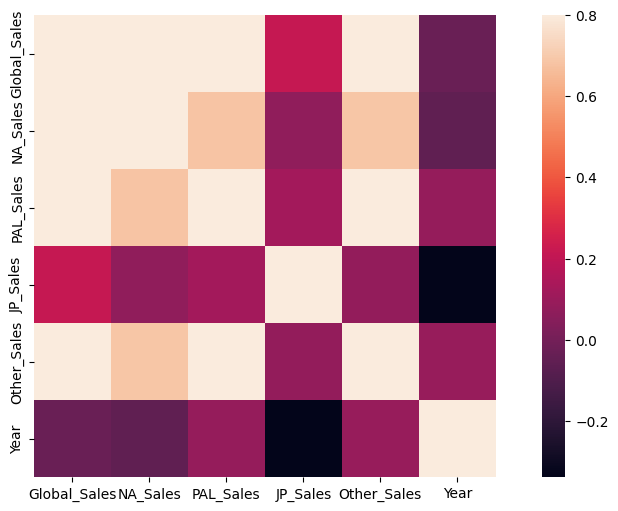

In [23]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), vmax=.8, square=True)

The heatmap indicates that there's strong correlation between NA_Sales, PAL_Sales, Other_Sales and Global_Sales. However, curiously, JP_Sales don't seem to correlate strongly with Global_Sales.

The features that are going to be used for our model will be: Genre, ESRB_Rating, Platform, Publisher, Developer, Year.

The label will be: Global_Sales

In [24]:
df = df.drop(labels=['NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales'], axis=1)
df.columns

Index(['Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer',
       'Global_Sales', 'Year'],
      dtype='object')

### Data Exploration

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df.columns

Index(['Name', 'Genre', 'ESRB_Rating', 'Platform', 'Publisher', 'Developer',
       'Global_Sales', 'Year'],
      dtype='object')

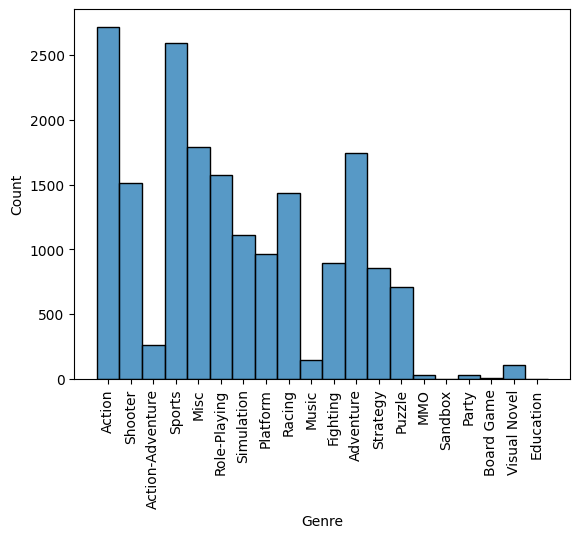

In [27]:
sns.histplot(df.Genre)
plt.xticks(rotation = 90)
plt.show()

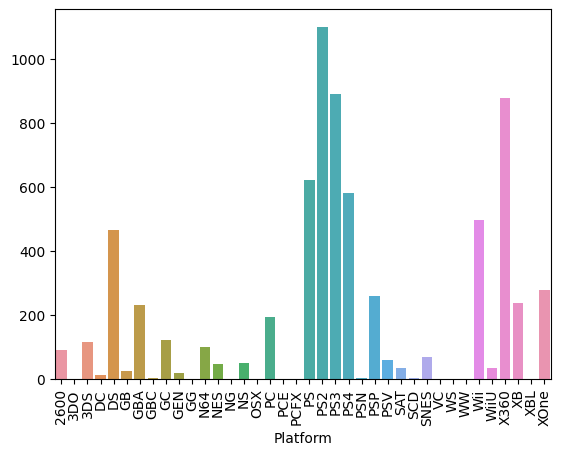

In [28]:
df_teste = df.groupby('Platform').Global_Sales.sum()
df_teste.reset_index(drop=True)
sns.barplot(df_teste.index, df_teste.values)
plt.xticks(rotation = 90)
plt.show()


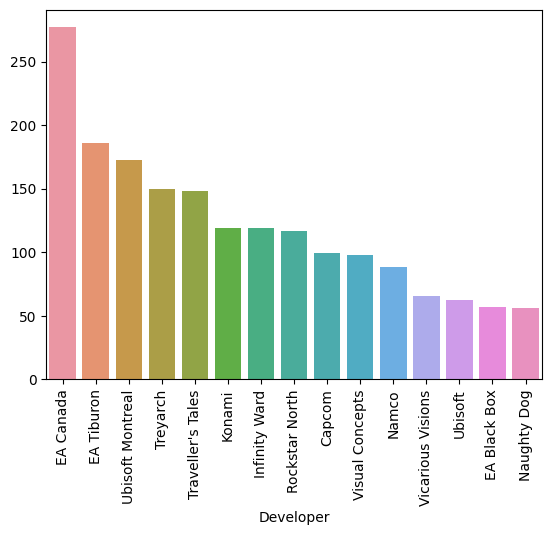

In [29]:
df_teste = df.groupby('Developer').Global_Sales.sum().sort_values(ascending=False)
df_teste.reset_index(drop=True)
sns.barplot(df_teste.index[:15], df_teste.values[:15])
plt.xticks(rotation = 90)
plt.show()


### Encoding

From the 6 features we have, 5 of them are nominal data, 4 of those being categorical (Genre, Platform, Publisher, Developer) and 1 being ordinal (ESRB_Rating).
All the nominal data must be encoded before applying it on the training of a model. Ideally, the nominal categorical data must be encoded in a way that doesn't create an order among the categories, so One-Hot-Encoded.

##### One-Hot-Encoding

In [30]:
print('Number of unique values per column:')
for c in df.columns:
    print(f'{c} : {df[c].unique().size}')

Number of unique values per column:
Name : 12633
Genre : 20
ESRB_Rating : 7
Platform : 38
Publisher : 716
Developer : 2851
Global_Sales : 510
Year : 46


Genre, Platform, Developer, Publisher are all nominal categorical features and therefore must be encoded.

In [31]:
#Create object for one-hot encoding
encoder=ce.OneHotEncoder(cols=['Genre', 'Publisher', 'Developer', 'Platform'],handle_unknown='return_nan',return_df=True,use_cat_names=True)

In [32]:
df[df.Global_Sales == 0]

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Global_Sales,Year
19862,Nari Kids Park: Ultraman R/B,Action,NaN,NS,Bandai Namco Games,Bandai Namco Games,0.0,2018.0
19863,Nekketsu Inou Bukatsu: Trigger Kiss,Adventure,NaN,PSV,Idea Factory,Idea Factory,0.0,2014.0
19864,Rampage Puzzle Attack,Puzzle,E,GBA,Midway Games,Ninai Games,0.0,2001.0
19865,Duke Nukem Trilogy: Critical Mass,Shooter,T,PSP,Unknown,FrontLine Studios,0.0,2001.0
19866,The World of Golden Eggs: Nori Nori Uta Dekich...,Puzzle,NaN,DS,AQ Interactive,AQ Interactive,0.0,2009.0
...,...,...,...,...,...,...,...,...
21237,"Mind, Body & Soul: Blend It!",Puzzle,NaN,DS,505 Games,Crush Digital,0.0,2010.0
21238,Ride! Carnival Tycoon,Strategy,E,PC,ValuSoft,ValuSoft,0.0,2007.0
21239,Shinobido: Tales of the Ninja,Action,NaN,PSP,Sony Computer Entertainment,Acquire,0.0,2007.0
21240,Tactical Ops: Assault on Terror,Shooter,NaN,PC,Atari,Kamehan Studios,0.0,2002.0


In [33]:
df_encoded = encoder.fit_transform(df)
df_encoded

,Name,Genre_Action,Genre_Shooter,Genre_Action-Adventure,Genre_Sports,Genre_Misc,Genre_Role-Playing,Genre_Simulation,Genre_Platform,Genre_Racing,...,Developer_GFI Russia,Developer_Total Eclipse,Developer_PomPom Games,Developer_Click Entertainment,Developer_iEntertainment Network,Developer_Streko-Graphics Inc.,Developer_Crush Digital,Developer_Kamehan Studios,Global_Sales,Year
19,Grand Theft Auto V,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.32,2013.0
20,Grand Theft Auto V,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.39,2014.0
30,Grand Theft Auto: Vice City,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.15,2002.0
32,Grand Theft Auto V,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.86,2013.0
34,Call of Duty: Black Ops 3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.09,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21237,"Mind, Body & Soul: Blend It!",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,2010.0
21238,Ride! Carnival Tycoon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2007.0
21239,Shinobido: Tales of the Ninja,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,2007.0
21240,Tactical Ops: Assault on Terror,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00,2002.0


In [34]:
df_encoded.shape

(18457, 3629)

The ESRB_Rating is a rating that indicates the age requirement in order to play a game. Because there's an order associated with that, it is a nominal ordinal category, and as such can be encoded through mapping each rating to a number. This has the advantage of not increasing the dimensionality of the data.

In [35]:
ord_encoder = ce.OrdinalEncoder(cols=['ESRB_Rating'],return_df=True,
                           mapping=[{'col':'ESRB_Rating',
'mapping':{np.nan:0,'RP':0,'E':0,'E10':1,'T':2,'M':3, 'EC':4}}])
df_encoded = ord_encoder.fit_transform(df_encoded)
df_encoded.shape

(18457, 3629)

#####  Label Encoding

In [36]:
# Import label encoder 
from sklearn import preprocessing
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder()
cols=['Genre', 'Publisher', 'Developer', 'Platform', 'ESRB_Rating']
df_label_encoded = pd.DataFrame(df)
for c in cols:
    df_label_encoded[c] = label_encoder.fit_transform(df[c])
print(df_label_encoded.head())


                           Name  Genre  ESRB_Rating  Platform  Publisher  \
19           Grand Theft Auto V      0            3        21        523   
20           Grand Theft Auto V      0            3        22        523   
30  Grand Theft Auto: Vice City      0            3        20        523   
32           Grand Theft Auto V      0            3        34        523   
34    Call of Duty: Black Ops 3     15            3        22         30   

    Developer  Global_Sales    Year  
19       2049         20.32  2013.0  
20       2049         19.39  2014.0  
30       2049         16.15  2002.0  
32       2049         15.86  2013.0  
34       2534         15.09  2015.0  


### Models

We're going to be using the HistGradientBoostingRegressor and the LGBMRegressor because they're supposed to be robust to a significant amount of nominal features.

In [37]:
model_names = []
best_scores = []
encoding = []

In [38]:
def run_model(model, X, y):
    cv = RepeatedKFold(n_splits=4, n_repeats=3, random_state=13)
    
    if model == 'hist':
        model = HistGradientBoostingRegressor()
    if model == 'lgbm':
        model = LGBMRegressor()
        
    n_scores = cross_val_score(model, X, y, scoring='r2', cv=cv, n_jobs=-1, error_score='raise')
    print('R2 Score (std) : %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

    return np.mean(n_scores)

##### HistGradientBoostingRegressor

In [39]:
X_encoded, y_encoded = df_encoded.drop(['Name', 'Global_Sales'], axis=1), df.Global_Sales

In [40]:
X_label_encoded, y_label_encoded = df_label_encoded.drop(['Name', 'Global_Sales'], axis=1), df.Global_Sales

In [41]:
model_names.append('HGB')
encoding.append('One-Hot')
best_scores.append(run_model('hist', X_encoded, y_encoded))


R2 Score (std) : 0.281 (0.045)


In [42]:
model_names.append('HGB')
encoding.append('Label')
best_scores.append(run_model('hist', X_label_encoded, y_label_encoded))

R2 Score (std) : 0.307 (0.036)


##### LGBMRegressor

In [43]:
df_encoded_lgbm = df_encoded.drop(['Name', 'Global_Sales'], axis=1)
df_encoded_lgbm = df_encoded_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_encoded_lgbm.columns = [str(c) + str(random.random()) for c in df_encoded_lgbm.columns]

X_encoded, y_encoded = df_encoded_lgbm, df.Global_Sales

In [44]:
df_label_encoded_lgbm = df_label_encoded.drop(['Name', 'Global_Sales'], axis=1)
df_label_encoded_lgbm = df_label_encoded_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_label_encoded_lgbm.columns = [str(c) + str(random.random()) for c in df_label_encoded_lgbm.columns]

X_label_encoded, y_label_encoded = df_label_encoded_lgbm, df.Global_Sales

In [45]:
model_names.append('LGBM')
encoding.append('One-Hot')
best_scores.append(run_model('lgbm', X_encoded, y_encoded))

R2 Score (std) : 0.288 (0.044)


In [46]:
model_names.append('LGBM')
encoding.append('Label')
best_scores.append(run_model('lgbm', X_label_encoded, y_label_encoded))

R2 Score (std) : 0.338 (0.037)


### Dimensionality Reduction

Because our dataset consists mainly of categorical features that can assume a wide variety of values, when encoded, the dimensionality significantly increases. High dimensionality is very harmful for Machine Learning models because it increases the content to be learned by the model, which can cause the model to need a larger dataset to learn from, which may cause underfitting.

After encoding, our dataset went from 6 features to 3629. We're going to try different methods of dimensionality reduction and verify if our dataset is good enough to create a model to predict the Global Sales of a given game.

##### Feature Selection

Publisher and Developer are features that most likely convey similar information: companies involved in the release of a game. As a Feature Selection approach, we're going to choose to drop the Developer column, because it has the higher dimensionality between the two features.

In [47]:
drop_columns = []
for i,v in enumerate(df_encoded.columns.map(lambda s : s.startswith('Developer'))):
    if v:
        drop_columns.append(df_encoded.columns[i])
df_encoded = df_encoded.drop(drop_columns, axis=1)
df_encoded.shape

(18457, 778)

In [48]:
drop_columns = []
for i,v in enumerate(df_label_encoded.columns.map(lambda s : s.startswith('Developer'))):
    if v:
        drop_columns.append(df_label_encoded.columns[i])
df_label_encoded = df_label_encoded.drop(drop_columns, axis=1)
df_label_encoded.shape

(18457, 7)

Let's train the models with the new dataset:

##### HistGradientBoostingRegressor

In [49]:
X_encoded, y_encoded = df_encoded.drop(['Name', 'Global_Sales'], axis=1), df.Global_Sales

In [50]:
model_names.append('HGB_Feature_Selection')
encoding.append('One-Hot')
best_scores.append(run_model('hist', X_encoded, y_encoded))

R2 Score (std) : 0.273 (0.043)


In [51]:
X_label_encoded, y_label_encoded = df_label_encoded.drop(['Name', 'Global_Sales'], axis=1), df.Global_Sales

In [52]:
model_names.append('HGB_Feature_Selection')
encoding.append('Label')
best_scores.append(run_model('hist', X_label_encoded, y_label_encoded))

R2 Score (std) : 0.279 (0.035)


##### LGBMRegressor

In [53]:
df_encoded_lgbm = df_encoded.drop(['Name', 'Global_Sales'], axis=1)
df_encoded_lgbm = df_encoded_lgbm.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_encoded_lgbm.columns = [str(c) + str(random.random()) for c in df_encoded_lgbm.columns]

X, y = df_encoded_lgbm, df.Global_Sales

In [54]:
model_names.append('LGBM_Feature_Selection')
encoding.append('One-Hot')
best_scores.append(run_model('lgbm', X, y))

R2 Score (std) : 0.281 (0.039)


##### PCA

In [55]:
from sklearn.preprocessing import StandardScaler
df_encoded_scaled = StandardScaler().fit_transform(df_encoded.drop(['Name', 'Global_Sales'], axis=1))

In [56]:
df_encoded_scaled = pd.DataFrame(df_encoded_scaled, columns=[df_encoded.columns.drop(['Name', 'Global_Sales'])])
df_encoded_scaled

,Genre_Action,Genre_Shooter,Genre_Action-Adventure,Genre_Sports,Genre_Misc,Genre_Role-Playing,Genre_Simulation,Genre_Platform,Genre_Racing,Genre_Music,...,Publisher_GTE Entertainment,Publisher_Game Factory Interactive,Publisher_The Fullbright Company,Publisher_Spellbound,Publisher_Futurlab 1,Publisher_Elephant Entertainment,Publisher_Adventure Soft,Publisher_TopWare,Publisher_iEntertainment Network,Year
0,2.405859,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,0.911803
1,2.405859,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,1.075374
2,2.405859,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,-0.887476
3,2.405859,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,0.911803
4,-0.415652,3.346482,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,1.238945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18452,-0.415652,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,0.421091
18453,-0.415652,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,-0.069621
18454,2.405859,-0.298821,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,-0.069621
18455,-0.415652,3.346482,-0.118831,-0.404292,-0.327817,-0.305017,-0.252716,-0.235007,-0.29002,-0.087739,...,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.007361,-0.01041,-0.007361,-0.887476


##### HistGradientBoostingRegressor

In [57]:
from sklearn.decomposition import PCA
from math import floor

In [58]:
feature_percentages = [0.05, 0.10, 0.15, 0.20]
means = []
for fp in feature_percentages:
    pca = PCA(n_components=floor(len(df_encoded_scaled.columns) * fp))
    principalComponents = pca.fit_transform(df_encoded_scaled)
    df_reduced = pd.DataFrame(principalComponents)
    X, y = df_reduced, df.Global_Sales
    print('Number of features: ', df_reduced.shape[1])
    m = run_model('hist', X, y)
    means.append(m)

Number of features:  38
R2 Score (std) : 0.246 (0.038)
Number of features:  77
R2 Score (std) : 0.264 (0.040)
Number of features:  116
R2 Score (std) : 0.272 (0.051)
Number of features:  155
R2 Score (std) : 0.268 (0.055)


In [59]:
table_pca = pd.DataFrame(zip(feature_percentages, means), columns=['feature_percentages', 'R2'])
table_pca

,feature_percentages,R2
0,0.05,0.246284
1,0.10,0.264134
2,0.15,0.271674
3,0.20,0.267926


In [60]:
model_names.append('HGB_PCA_' + str(table_pca.feature_percentages.iloc[table_pca.R2.idxmax()]))
encoding.append('One-Hot')
best_scores.append(table_pca.R2.max())

In [61]:
X, y = df_encoded.drop(['Name', 'Global_Sales'], axis=1), df.Global_Sales

In [62]:
from sklearn.decomposition import NMF

components = range(2,24,2)
means = []
for nc in components:
    model = NMF(n_components=nc, init='random', random_state=0)
    W = model.fit_transform(X)
    H = model.components_
    m = run_model('hist', W, y)
    means.append(m)

R2 Score (std) : 0.076 (0.019)
R2 Score (std) : 0.076 (0.019)
R2 Score (std) : 0.060 (0.024)
R2 Score (std) : 0.125 (0.038)
R2 Score (std) : 0.156 (0.040)
R2 Score (std) : 0.182 (0.028)
R2 Score (std) : 0.206 (0.036)
R2 Score (std) : 0.198 (0.036)
R2 Score (std) : 0.215 (0.040)
R2 Score (std) : 0.212 (0.032)
R2 Score (std) : 0.215 (0.030)


In [63]:
table_nmf = pd.DataFrame(zip(components, means), columns=['number_components', 'R2'])
table_nmf

,number_components,R2
0,2,0.075773
1,4,0.075539
2,6,0.059897
3,8,0.124553
4,10,0.155800
5,12,0.181762
6,14,0.206017
7,16,0.198010
8,18,0.214507
9,20,0.212057


In [64]:
model_names.append('HGB_NMF_' + str(table_nmf.number_components.iloc[table_nmf.R2.idxmax()]))
encoding.append('One-Hot')
best_scores.append(table_nmf.R2.max())

### Results

In [65]:
results = pd.DataFrame(zip(model_names, encoding, best_scores), columns=['Model', 'Encoding', 'R2 Score'])
results

,Model,Encoding,R2 Score
0,HGB,One-Hot,0.281415
1,HGB,Label,0.307230
2,LGBM,One-Hot,0.288356
3,LGBM,Label,0.337939
4,HGB_Feature_Selection,One-Hot,0.272949
5,HGB_Feature_Selection,Label,0.279237
6,LGBM_Feature_Selection,One-Hot,0.280503
7,HGB_PCA_0.15,One-Hot,0.271674
8,HGB_NMF_22,One-Hot,0.215263


### Conclusion

None of the models got a R2 Score of over 0.6, which is the threshold for the model to be considered functional. Therefore our dataset was not able to provide enough data in order to achieve what was intended: a model capable of predicting videogames' sales.
This probably occured because our final dataset had not enough entries or features. Almost all of the features were also high cardinality nominal categorical features, which causes the cardinality of the dataset to increase sigificantly with very little control. Steps were taken in order to try to reduce the cardinality of the dataset. First of all, instead of One-Hot-Encoding, we tried Label Encoding. Eventhough label encoding shouldn't usually be used for categorical features because it introduces an order to the feature that is highly likely to be misinterpreted by the model, our categorical features had high enough cardinality to make it worth the try. As can be seen, our Label-Encoded dataset performed better in all of the models, but still not well enough to be considered functional. Another cardinality reduction approach was to drop the highest cardinality column: Developer. The logic here is that the cardinality is way too high and also it might represent something similar to the column Publisher, both are ultimately companies involved in the creating of a game. This approach didn't succeed and in fact it dropped our R2 scores. Next, we applied two different approaches to the One-Hot-Encoded dataset: PCA and NMF. In both of these methods we get to choose the cardinality of our final vector. We implemented them in a way we would experiment with different cardinalities and choose the one that performed the best. For the PCA the best-performing one had 15% of the size of the original vector. For the NMF method the best-performing datased had 16 components. PCA managed to perform slightly better than the orginal HGB method, but worse than the original LGBM method. NMF performed the worst of all the methods tried.

Our best scoring model was LGBM trained with label-encoded dataset. Its R2 score was 0.351371, which is not enough to say it is functional.